In [1]:
!pip install seaborn
!pip install scikit-image
!pip install nilearn

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif
from IPython.display import display, Image


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-283ezfho
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-283ezfho
  Resolved https://github.com/miykael/gif_your_nifti to commit fc21f44a57d04a6ae471ba4be6da0f904d830669
  Preparing metadata (setup.py) ... done


2024-01-31 09:15:00.688435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 09:15:00.688500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 09:15:00.690013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# **Image data descriptions**
All BraTS multimodal scans are available as NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

* T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
* T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
* T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
* FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

Text(0.5, 1.0, 'Mask')

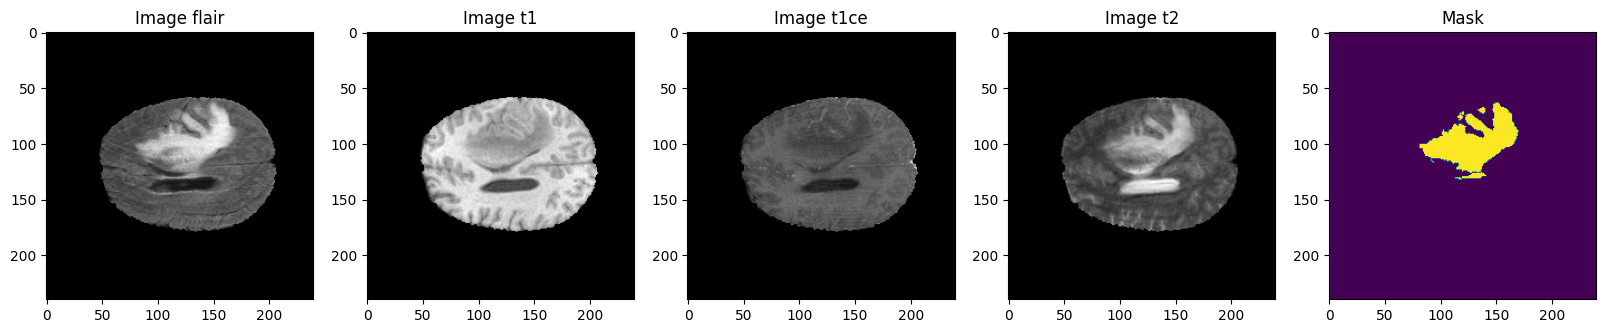

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [ ]:

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Check if the background of images contains only zero values** Visualize zero values in image (black values ==> background) , converted into another color so its easier to see

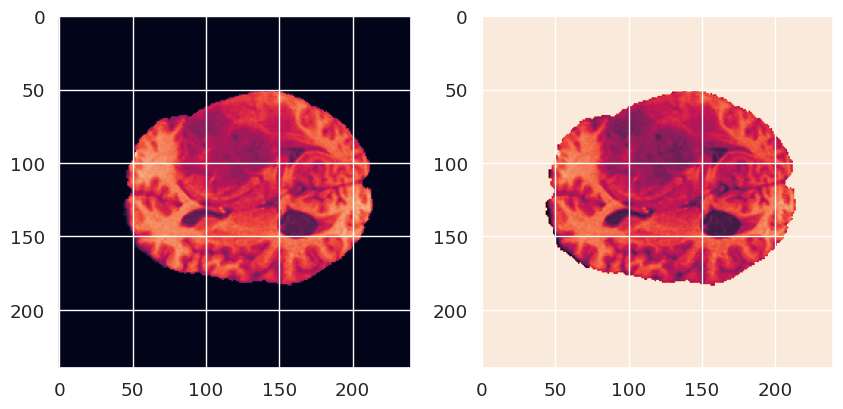

In [67]:

my_loc_slice=73
image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666


f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

**Show segment of tumor for each above slice**

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [6]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Create a GIF**

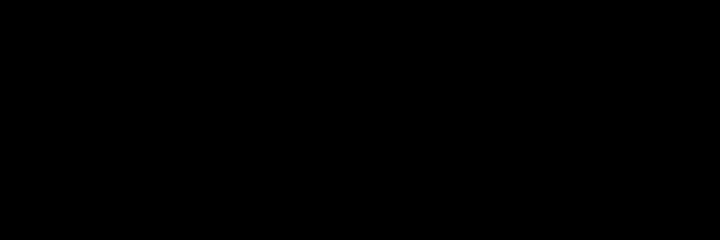

In [7]:
gif_path = '/kaggle/working/test_gif_BraTS20_Training_001_flair.gif'

display(Image(filename=gif_path))

**Show segments of tumor using different effects**

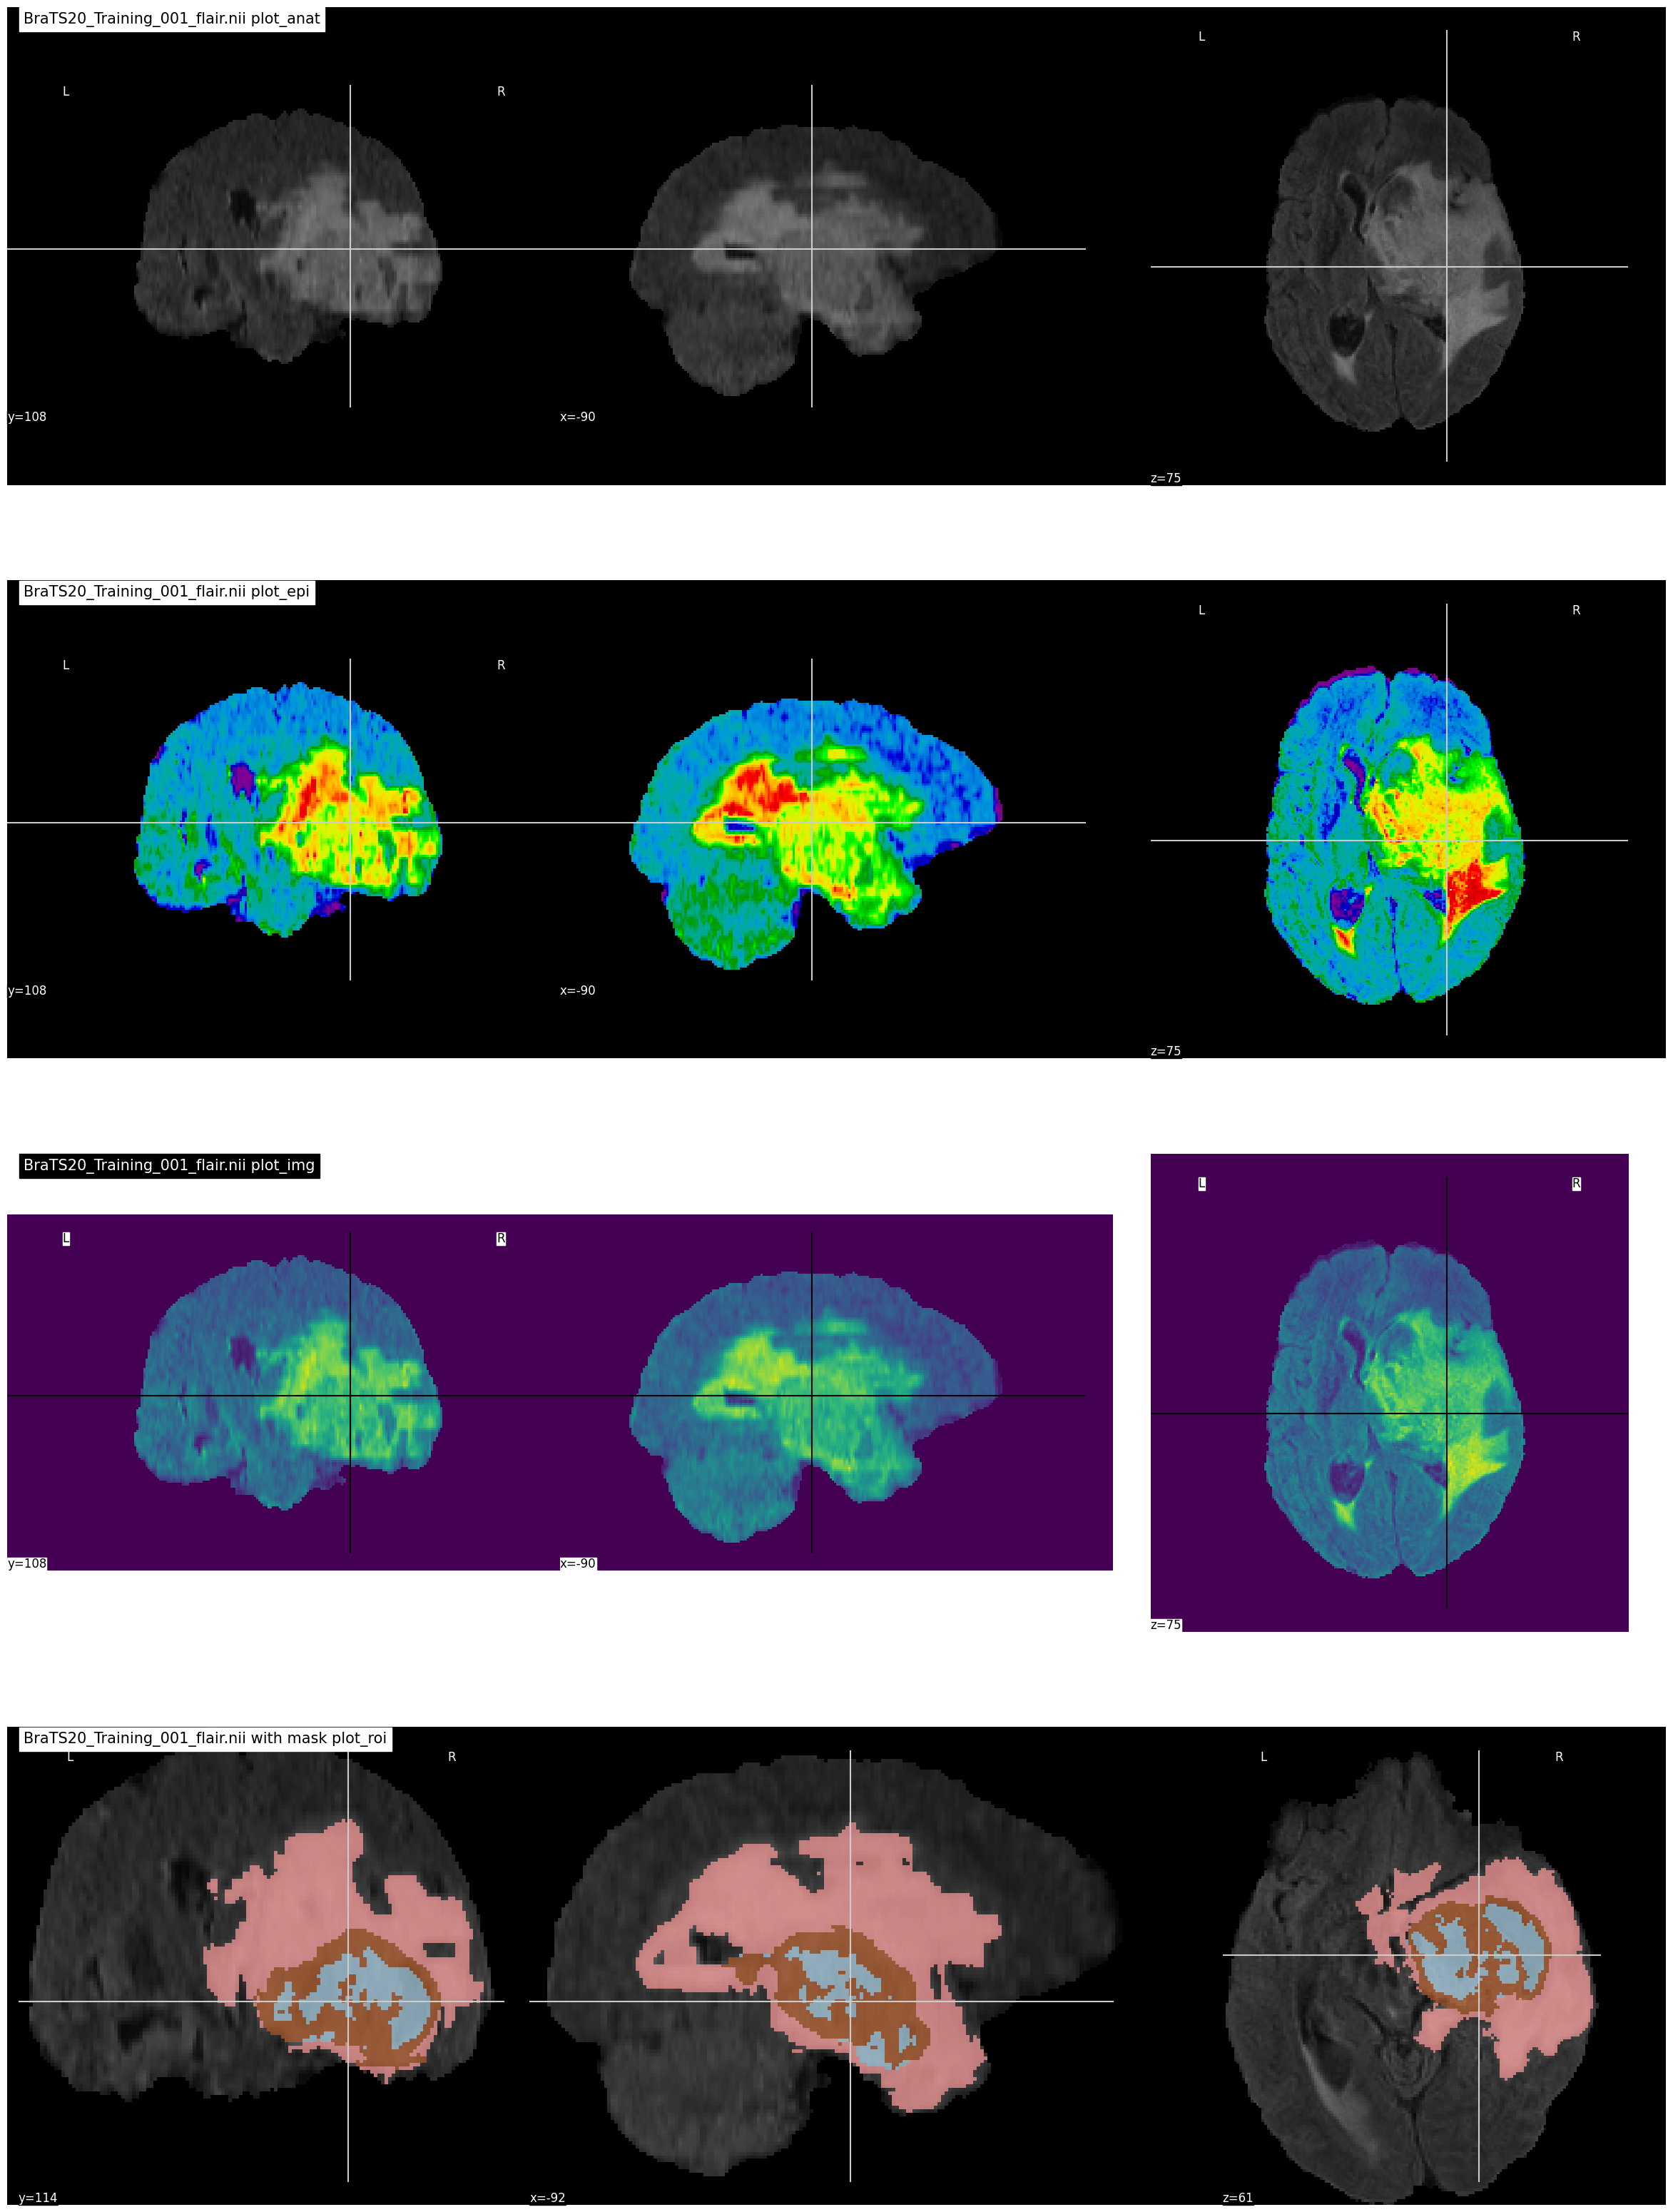

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

# **Create model || U-Net: Convolutional Networks for Biomedical Image Segmentation**

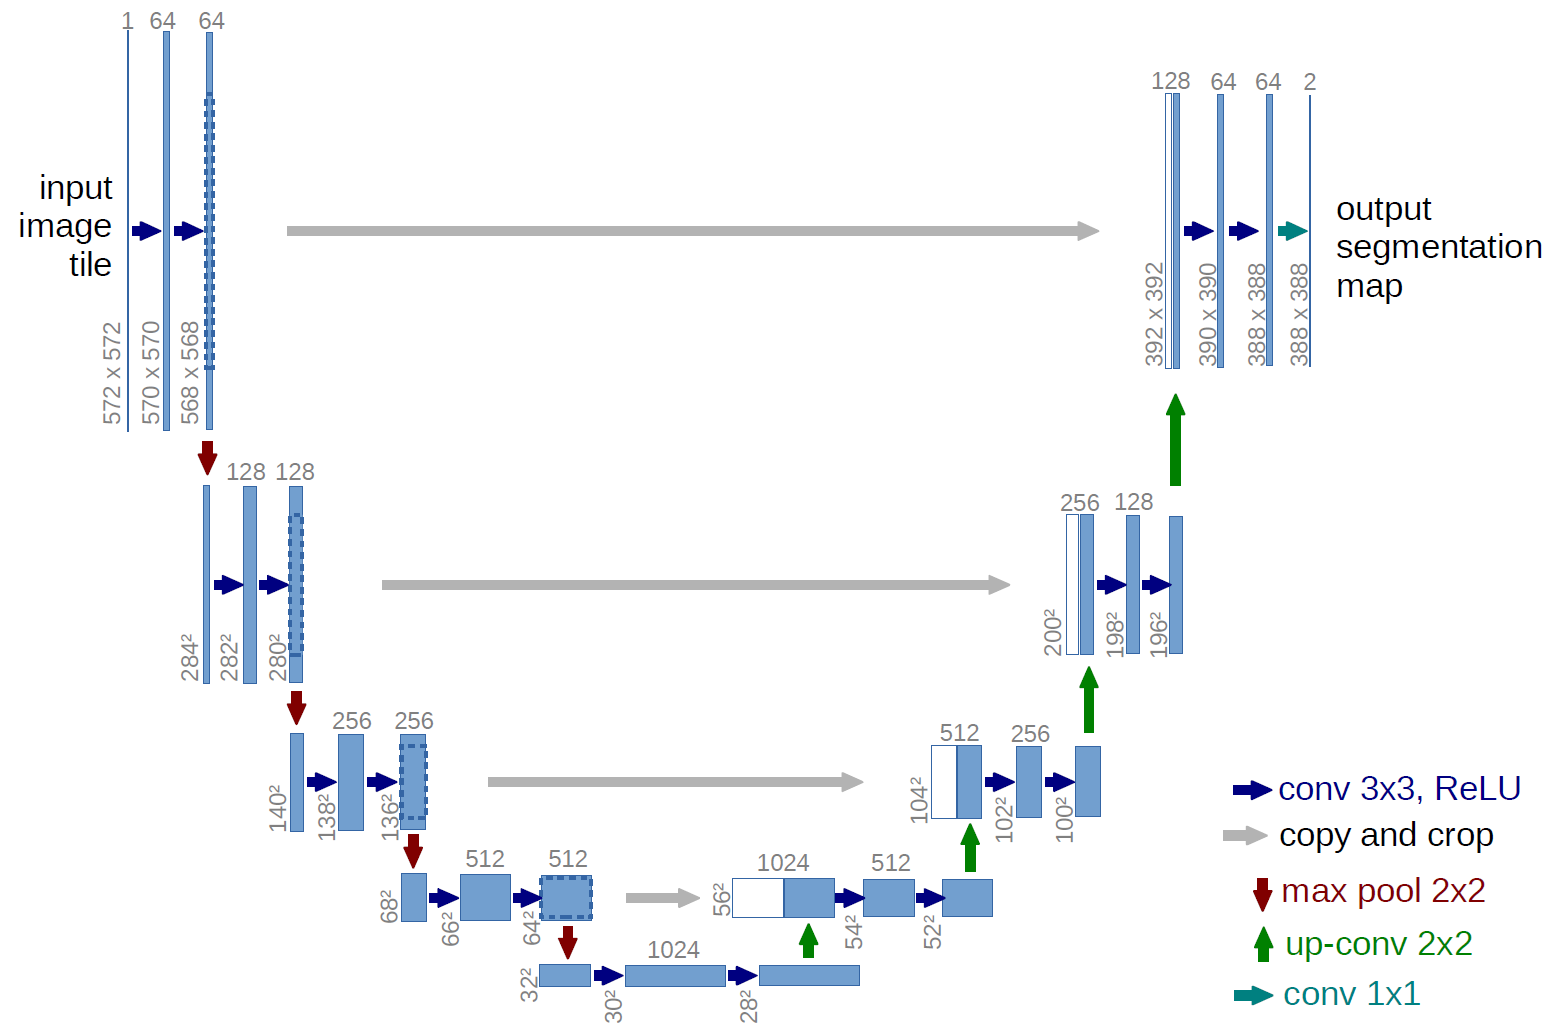

In [9]:
img1 = '/kaggle/input/unetdiagr/unetdiagr.png'

display(Image(filename=img1))

# **Loss Function**

**Dice coefficient**, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

In [10]:
img2 = 'https://camo.githubusercontent.com/63f2dcb435547630ef978b588be21b5b5cdfe68bb0affe240c1fe6838b11bf79/68747470733a2f2f77696b696d656469612e6f72672f6170692f726573745f76312f6d656469612f6d6174682f72656e6465722f7376672f61383061393732313565316166633062323232653630346166316232303939646339333633643362'

display(Image(url=img2))

**As matrices:**

In [11]:
img3 = 'https://camo.githubusercontent.com/e58a4df6e4cfbbfad1b8ea7dc1deeea5316412c19d40547731713e8a4a111217/68747470733a2f2f7777772e6a6572656d796a6f7264616e2e6d652f636f6e74656e742f696d616765732f323031382f30352f696e74657273656374696f6e2d312e706e67'

display(Image(url=img3))

In [12]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


# jaccard's loss
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
IMG_SIZE=128

In [14]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

**Model Architecture**
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

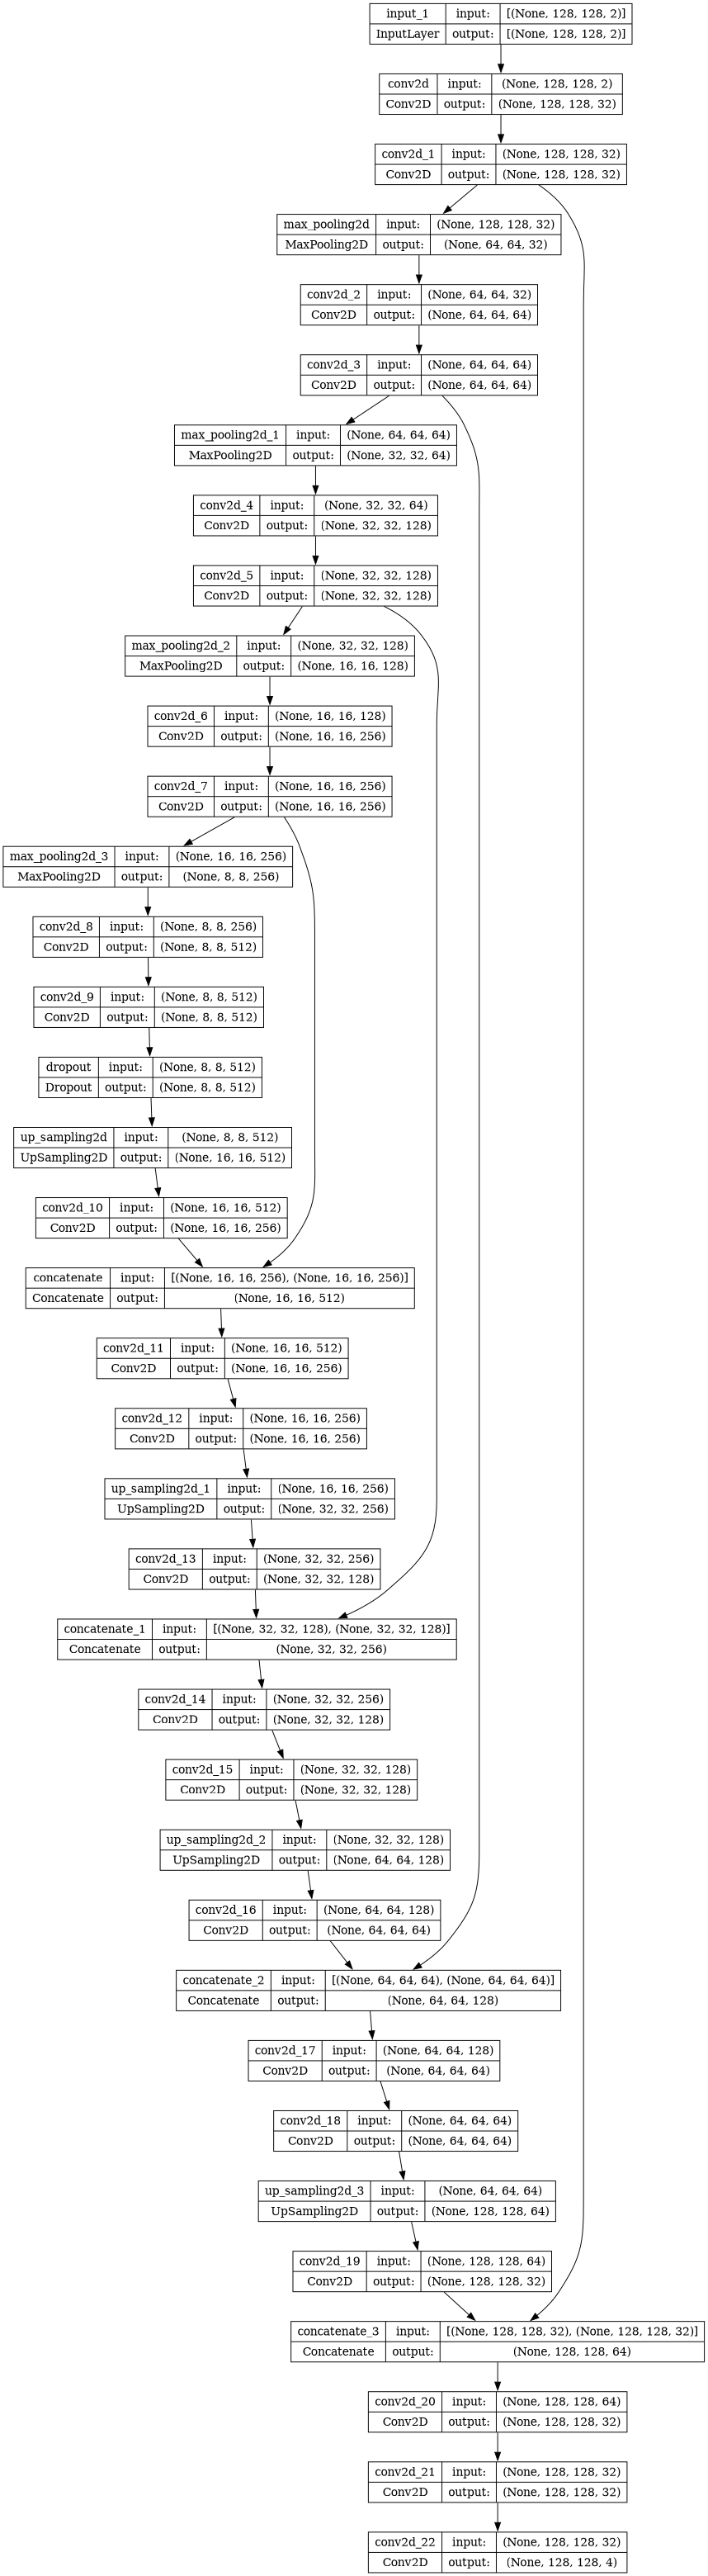

In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# **Load Data**
Loading all data into memory is not a good idea since the data are too big to fit in. So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Override Keras sequence DataGenerator class**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used for training / testing / validation**

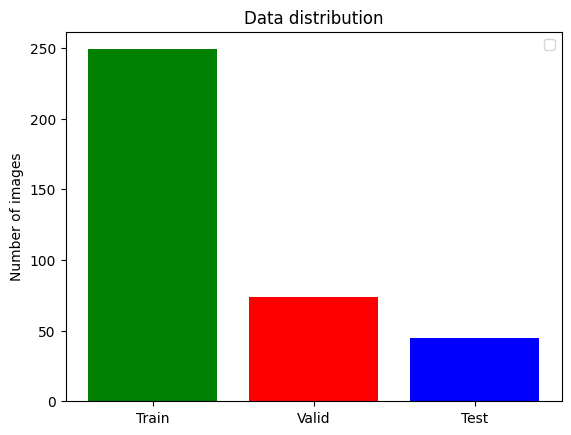

In [ ]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# **Train model**

The best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss
I will load this pretrained model instead of training again

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                     epochs=1,  #I used 1 for the sake of time management. Use 35 or more when time is not an issue
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model.save("model_x1_1.keras")

2024-01-31 09:15:28.735829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706692536.301510    2026 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 [==============================] - 143s 481ms/step - loss: 68629480.0000 - accuracy: 0.9500 - mean_io_u: 0.9002 - dice_coef: 0.2495 - precision: 0.9497 - sensitivity: 0.9477 - specificity: 0.9837 - dice_coef_necrotic: 1.4343e-04 - dice_coef_edema: 3.0646e-04 - dice_coef_enhancing: 1.0188e-04 - val_loss: 2903457.0000 - val_accuracy: 0.9822 - val_mean_io_u: 0.9777 - val_dice_coef: 0.2485 - val_precision: 0.9822 - val_sensitivity: 0.9823 - val_specificity: 0.9941 - val_dice_coef_necrotic: 0.0000e+00 - val_dice_coef_edema: 0.0000e+00 - val_dice_coef_enhancing: 0.0000e+00 - lr: 0.0010


**Visualize the training process**

# **For the following, we cannot see anything because ONLY 1 epoch was performed**

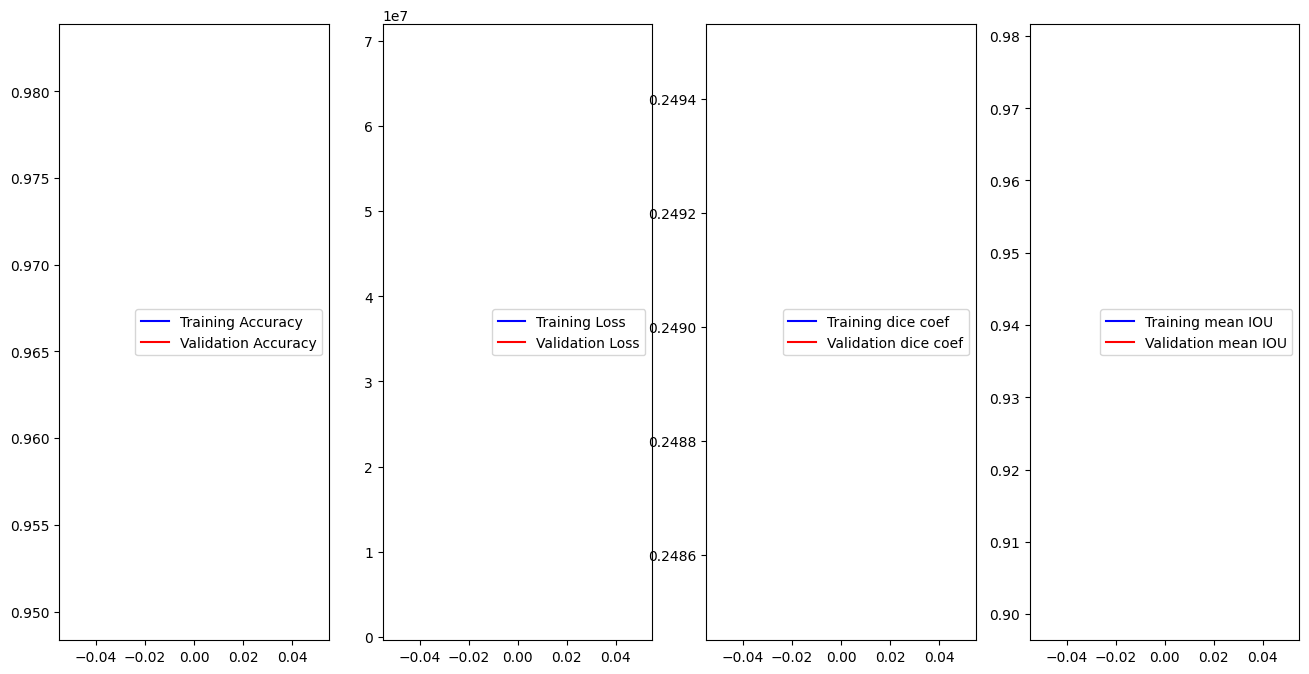

In [24]:
############ load trained model ################
model = keras.models.load_model('/kaggle/working/model_x1_1.keras', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

#hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# **Prediction Examples**

In [25]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 [==============================] - 3s 280ms/step


<Figure size 1800x5000 with 0 Axes>

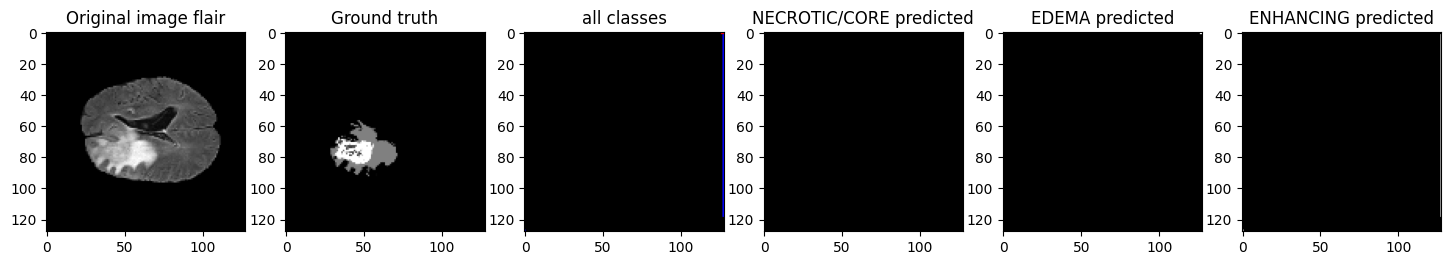

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

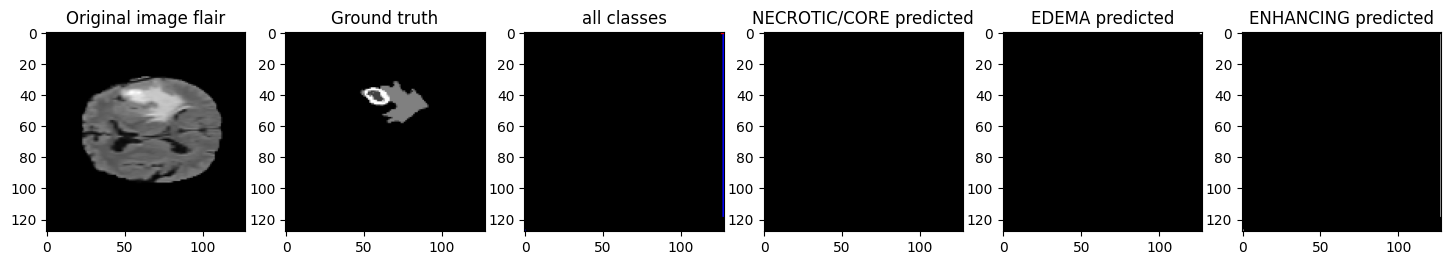

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

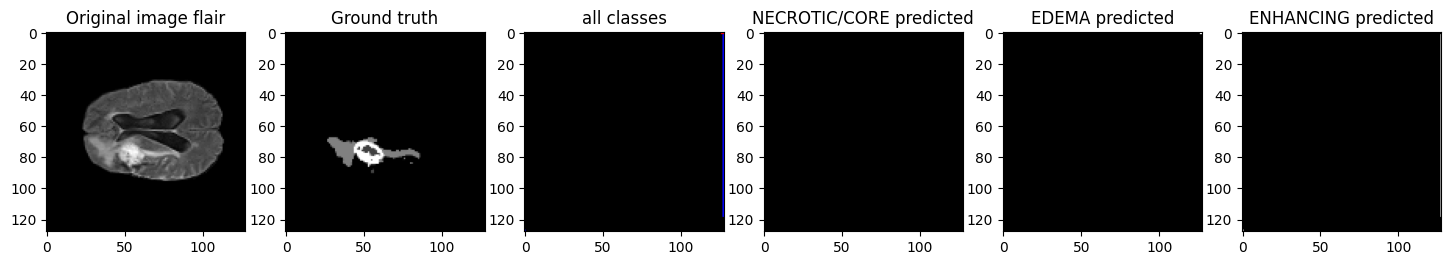

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

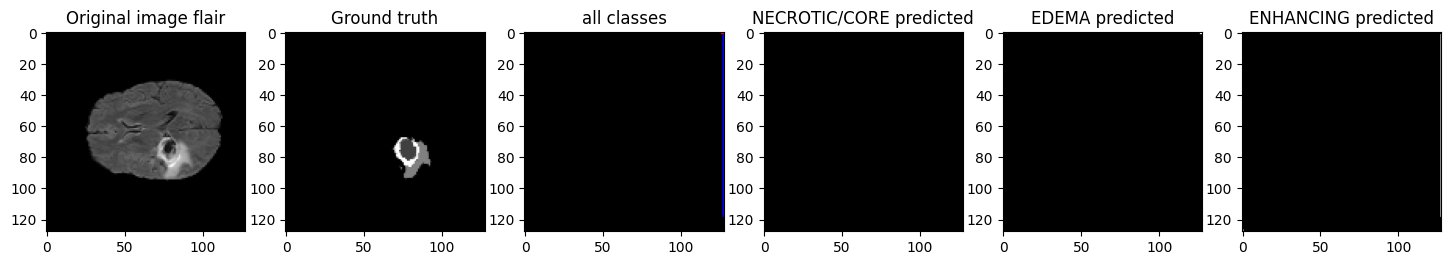

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

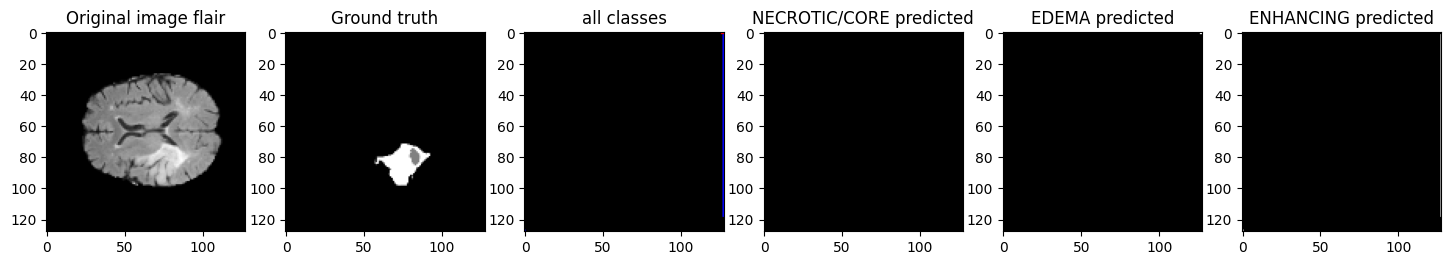

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

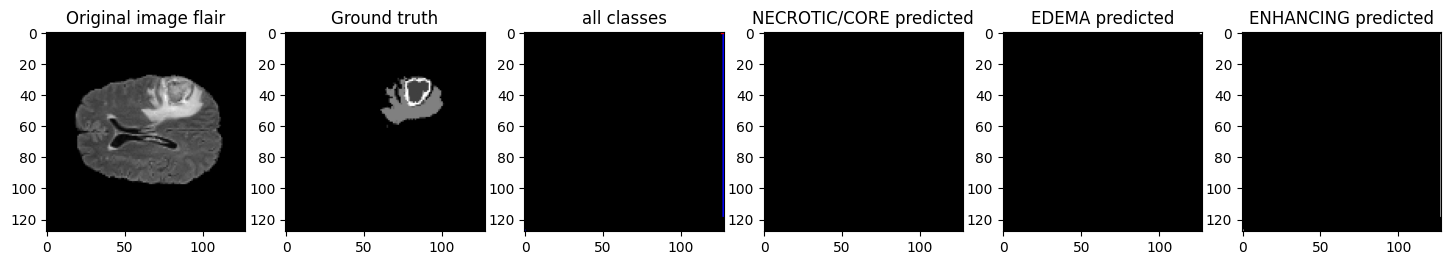

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

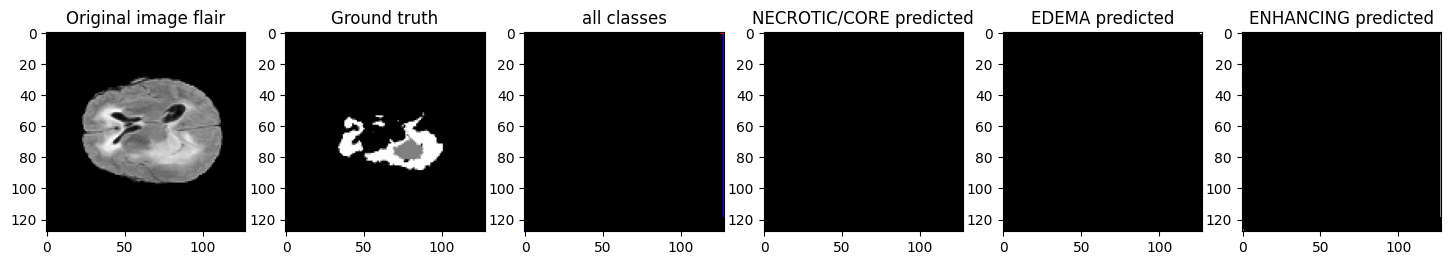

In [26]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="gray")
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="gray")
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="gray")
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="gray")
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

# **Evaluation**

4/4 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

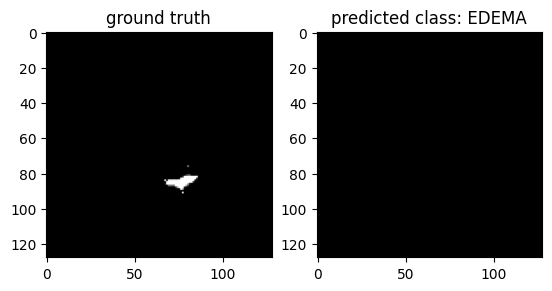

In [27]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


# gt_resized = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
# for j in range(VOLUME_SLICES):
#     gt_resized[j,:,:] = cv2.resize(gt[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 0 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [29]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 13s 260ms/step - loss: 3171172.7500 - accuracy: 0.9811 - mean_io_u_5: 0.9761 - dice_coef: 0.2483 - precision: 0.9811 - sensitivity: 0.9811 - specificity: 0.9937 - dice_coef_necrotic: 0.0000e+00 - dice_coef_edema: 0.0000e+00 - dice_coef_enhancing: 0.0000e+00
test loss, test acc: [3171172.75, 0.9810726046562195, 0.976132333278656, 0.248344287276268, 0.9810681939125061, 0.9810929894447327, 0.9936896562576294, 0.0, 0.0, 0.0]


# **Survival prediction**

**Lets see what is the age distrubution in our dataset and their survival days**

In [43]:
import csv

csv_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


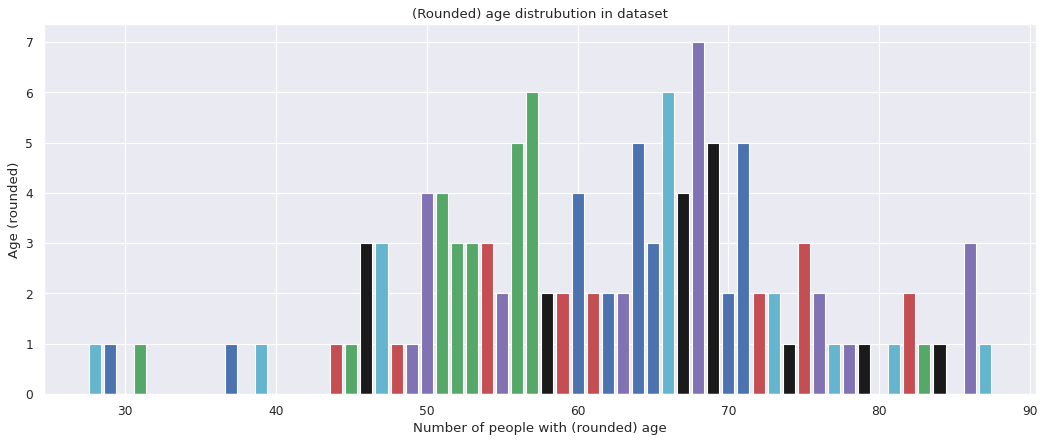

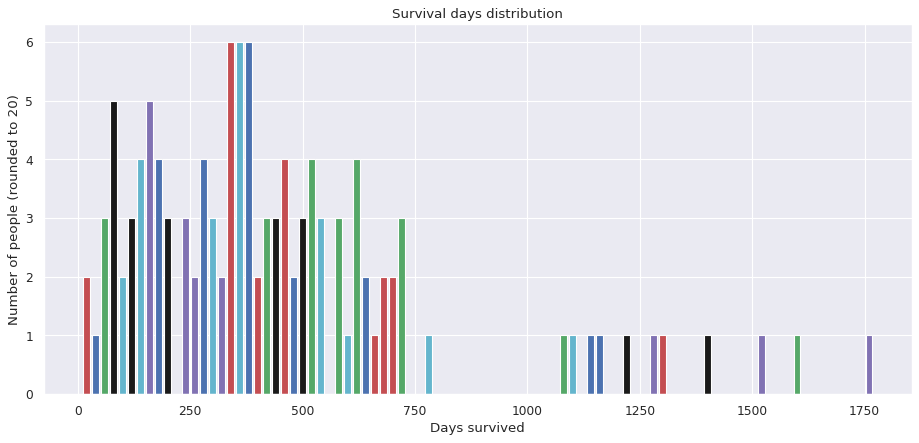

In [44]:
from collections import Counter
from itertools import cycle
#age_dict, days_dict 

# round values in dictionary
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}
# survival days are very distinct values => move the values in ranges per 20
days_dict_rounded = {key : round(days_dict[key]/20)*20 for key in days_dict}

# count same numbers => create statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))
    
cycol = cycle('bgrcmk')    
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color=colors)
plt.show()

plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=15, color=colorsDays)
plt.show()

# **Computing segment sizes**

Find number of pixels for each class in volume, no need to compute as ration to image size, since all images are of same size 240x240

In [45]:
# get number of pixels for each segment as dictionary
# original images contain segment values (0,1,2,4) => 4 is our 3 ... :)
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

**Compute brain volume size** => ignore background

total count: 1264556


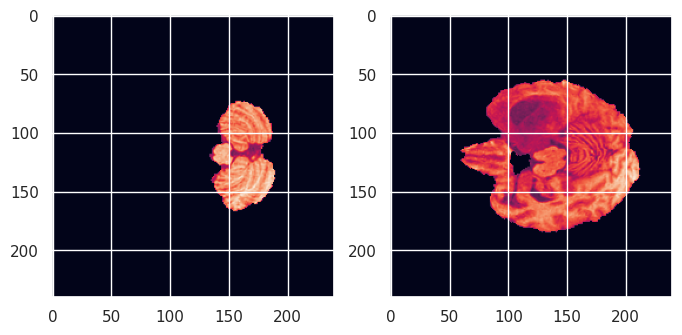

In [46]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [47]:
# create only age: category data

# id: age, categories
def getListAgeDays(id_list):
    x_val = []
    y_val = []
    for i in id_list:
        if (i not in age_dict):
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        x_val.append(merged) 
        if (days_dict[i] < 250):
            y_val.append([1,0,0])
        elif (days_dict[i] >= 250 and days_dict[i] < 450):
            y_val.append([0,1,0])
        else:
            y_val.append([0,0,1])
            
    return np.array(x_val), np.array(y_val)

X_all, y_all = getListAgeDays(train_and_test_ids)

print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df.head()

X_test: (118, 4)


age  NECROTIC/CORE     EDEMA  ENHANCING  short  medium  long
0  54.915       0.002438  0.045368   0.005153    0.0     1.0   0.0
1  57.000       0.015202  0.039171   0.019636    0.0     0.0   1.0
2  60.000       0.004592  0.027417   0.030548    0.0     0.0   1.0
3  83.649       0.039530  0.048636   0.025146    0.0     1.0   0.0
4  60.019       0.000448  0.018200   0.007183    0.0     1.0   0.0

**Normalize data**

In [48]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
display(df)

age normalised  NECROTIC/CORE     EDEMA  ENHANCING
0          0.460631       0.060053  0.330630   0.105513
1          0.496066       0.374441  0.283556   0.406350
2          0.547051       0.113117  0.194263   0.633018
3          0.948964       0.973691  0.355460   0.520813
4          0.547373       0.011033  0.124241   0.147677
..              ...            ...       ...        ...
113        1.000000       0.337023  0.507990   0.673251
114        0.795687       0.207157  0.222702   0.605692
115        0.779440       0.037349  0.208887   0.115095
116        0.807277       0.383568  0.179196   0.338549
117        0.371000       0.069379  0.095903   0.263933

[118 rows x 4 columns]

**View Distributions**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

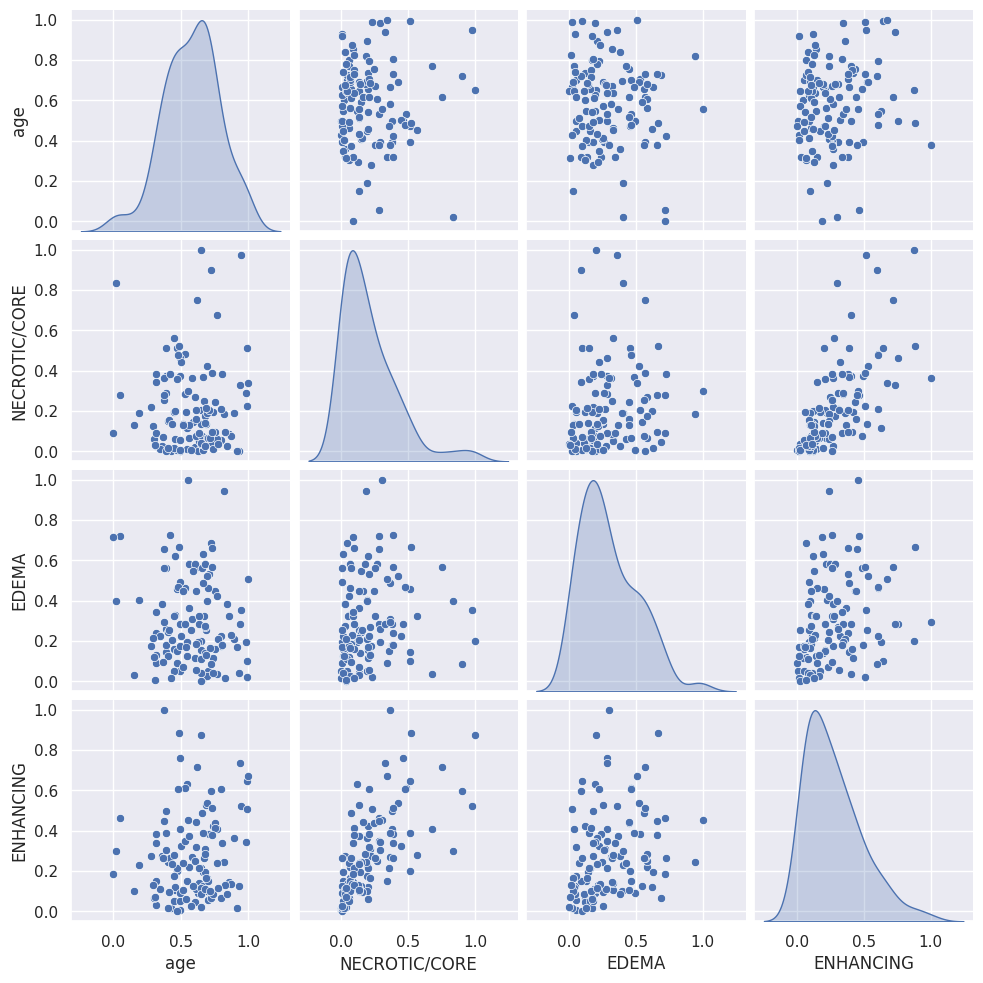

In [49]:
sns.set()

df = pd.DataFrame(X_all, columns = ["age", SEGMENT_CLASSES[1],SEGMENT_CLASSES[2],SEGMENT_CLASSES[3]])
sns.pairplot(df, diag_kind='kde')

**Data split**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


**Random forest**

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=3, random_state=0)

# fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score with 3 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))



accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
# rfc.fit(X_train,y_train)

print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Model accuracy score with 3 decision-trees : 0.5417
Cross validation: Train Score: 0.24428763440860216
Cross validation: Test Score: 0.5416666666666666


   **Visualize the most important features**  We can see that the most important feature is age

In [52]:
df = pd.DataFrame(X_train, columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

age              0.323315
NECROTIC/CORE    0.265839
ENHANCING        0.209758
EDEMA            0.201087
dtype: float64

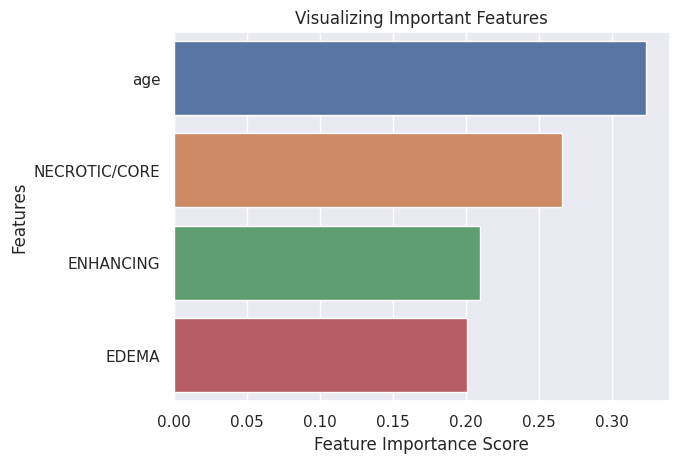

In [53]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

**Confusion matrix**

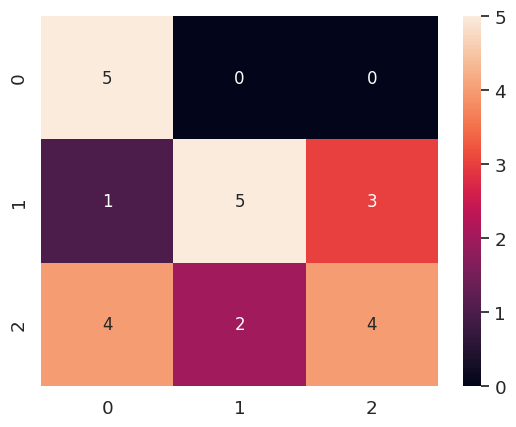

In [54]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.71      0.56      0.63         9
           2       0.57      0.40      0.47        10

   micro avg       0.59      0.54      0.57        24
   macro avg       0.60      0.59      0.57        24
weighted avg       0.61      0.54      0.56        24
 samples avg       0.54      0.54      0.54        24



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Gridsearch**
To find best score, I will try different value of:

1. n_estimators -> in range (1,100) with step 1
2. criterion parameters -> gini and entropy

In [56]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['gini','entropy']
    }

rfc_ = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

print("Hyperparameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

Hyperparameters: {'criterion': 'gini', 'n_estimators': 1}
Train Score: 0.42339181286549704
Test Score: 0.4583333333333333


**SVM Classifier**

In [57]:
from sklearn.svm import SVC

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
accuracies = cross_val_score(svc, X_train, y_train_multi)
svc.fit(X_train,y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",svc.score(X_test,y_test_multi))

Model accuracy score : 0.5000
Cross validation: Train Score: 0.5216374269005847
Cross validation: Test Score: 0.5


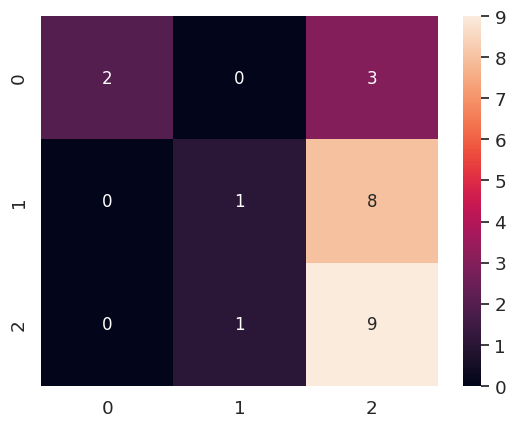

In [60]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [61]:
print(classification_report(y_test_multi, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      0.11      0.18         9
           2       0.45      0.90      0.60        10

    accuracy                           0.50        24
   macro avg       0.65      0.47      0.45        24
weighted avg       0.58      0.50      0.44        24



**GridSearch**
To find best score, I will try different value of:

1. C -> Regularization parameter
2. kernel -> Specifies the kernel type to be used in the algorithm
3. degree -> Degree of the polynomial kernel function
4. gamma -> Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

In [62]:
grid = {
    'C':[0.01,0.1,1,10,15,20],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

svm  = SVC();
svm_grid = GridSearchCV(svm, grid, cv = 5)
svm_grid.fit(X_train,y_train_multi)
print("Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_)
print("Test Score:",svm_grid.score(X_test,y_test_multi))

Best Parameters: {'C': 10, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
Train Score: 0.5216374269005847
Test Score: 0.5


**KNN Classifier**

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
accuracies = cross_val_score(knn, X_train, y_train_multi)
knn.fit(X_train,y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",knn.score(X_test,y_test_multi))

Model accuracy score : 0.5417
Cross validation: Train Score: 0.49941520467836253
Cross validation: Test Score: 0.5416666666666666


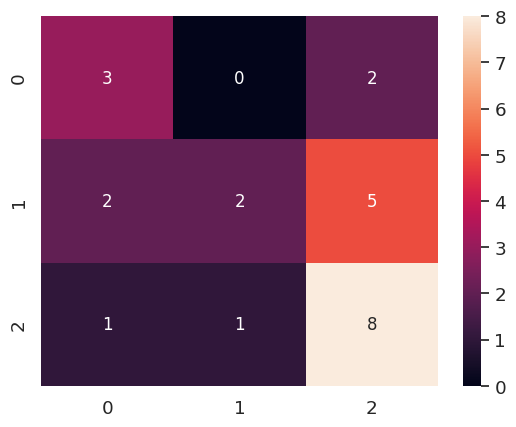

In [64]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [65]:
print(classification_report(y_test_multi, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.67      0.22      0.33         9
           2       0.53      0.80      0.64        10

    accuracy                           0.54        24
   macro avg       0.57      0.54      0.51        24
weighted avg       0.58      0.54      0.51        24



**GridSearch**
To find best score, I will try different value of:

1. n_neighbors -> Number of neighbors to use by default for kneighbors queries
2. p -> Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance
3. weights -> weight function used in prediction

In [66]:
grid = {
    'n_neighbors':np.arange(1,75),
    'p':np.arange(1,5),
    'weights':['uniform','distance']
    }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid,cv=5)
knn_grid.fit(X_train,y_train_multi)

print("Hyperparameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_)
print("Test Score:",knn_grid.score(X_test,y_test_multi))

Hyperparameters: {'n_neighbors': 38, 'p': 2, 'weights': 'distance'}
Train Score: 0.49941520467836253
Test Score: 0.5416666666666666
